### Задача:

На основе данных узнать, можно ли использовать для стат.оценки критерий Стьюдента.     
Метрика – ARPU    
В процессе решения задачи необходимо ответить на следующие вопросы:     
1) Как распределена t статистика при верности нулевой гипотезы   
2) Как распределен pValue при верности нулевой гипотезы     
3) Как распределена разница средних  

Ответы:      
1) Симметрично   
2) Равномерно   
3) Нормально

In [1]:
import pandas as pd
import numpy as np
# виз
from tqdm import tqdm  
from time import sleep 
import matplotlib.pyplot as plt
# стат
from scipy.stats import norm
from scipy import stats

In [2]:
df = pd.read_csv('skyeng_day2.csv') 

In [3]:
df.head()

,user,check
0,67499.158175,0.0
1,83340.158176,0.0
2,85529.158172,0.0
3,197806.157903,0.0
4,221230.158178,0.0


In [4]:
# первая половина выборки
data_column_1 = df.sample(frac = 0.5)
 
# вторая половина выборки
data_column_2 = df.drop(data_column_1.index)

### Распределение разницы средних

In [5]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):

    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_2), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {#"boot_data": boot_data, закомментировано, чтобы не перегружать виз
            "ci": ci, 
            "p_value": p_value}

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 791.98it/s]


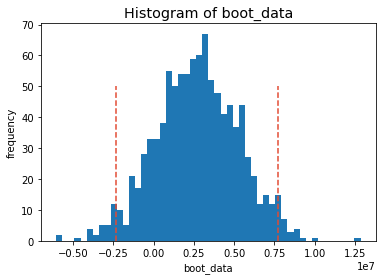

{'boot_data': [5229509.150652826,
  6419029.822100401,
  332230.5187160969,
  1878854.400969386,
  -1502068.8507341743,
  -215297.30346781015,
  5401921.685030997,
  2740139.858682394,
  527620.2927699089,
  -2042412.3163116574,
  6532452.5204696655,
  2975121.2080504894,
  -1274713.465454042,
  1530072.2100566626,
  -2350194.874400556,
  4996299.359550953,
  5490574.72994256,
  1004264.9841617346,
  7808732.222802758,
  -559394.7399818301,
  2948110.5987565517,
  5831379.469424486,
  3322737.352178693,
  -1534377.9459207654,
  1993915.0690734386,
  4942036.33811295,
  6894633.016601741,
  271381.3224148154,
  1557690.406909883,
  2447536.313334167,
  -1032904.2223688364,
  -87658.91608822346,
  2777634.798766196,
  5909609.632157445,
  2455325.195963204,
  116688.2498574853,
  3195314.0938469768,
  1968943.8518189192,
  113733.75554287434,
  7706506.679425538,
  7092961.774186373,
  8140390.669001758,
  2467125.3707371354,
  -106866.15856391191,
  -1189694.2289928794,
  2473568.705370

In [6]:
get_bootstrap(data_column_1, data_column_2, boot_it = 1000, statistic = np.mean, bootstrap_conf_level = 0.95)

### Распределение pValue, t статистики и fpr (на рандоме exponential)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 233.07it/s]


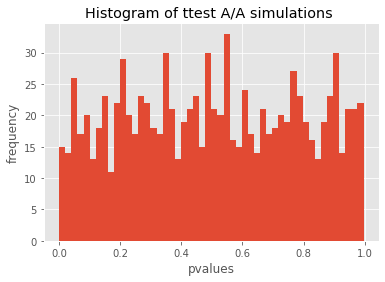

In [7]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df = pd.DataFrame({
    "s1": np.random.exponential(scale=1/0.001, size=n),
    "s2": np.random.exponential(scale=1/0.001, size=n)
})


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df['s1'].sample(n_s, replace = False).values
    s2 = df['s2'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [8]:
# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

0.041

In [9]:
sum(np.array(res) <0.01) / simulations

0.009

In [10]:
sum(np.array(res) <0.1) / simulations

0.092

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 231.55it/s]


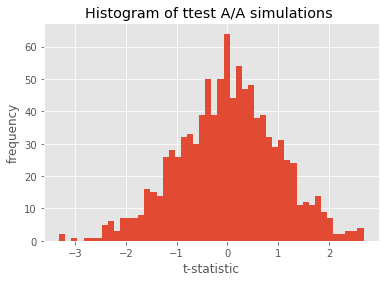

In [11]:
# Запуск симуляций A/A теста
# Распределение t статистики
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df['s1'].sample(n_s, replace = False).values
    s2 = df['s2'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[0]) # сохраняем t-статистику

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('t-statistic')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

### Распределение pValue, t статистики и fpr (на заданном датасорсе)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 682.74it/s]


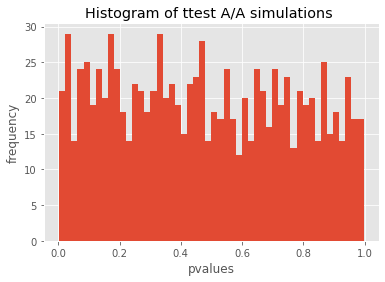

In [12]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
# Распределение pValue
for i in tqdm(range(simulations)):
    s1 = data_column_1['check'].sample(n_s, replace = False).values
    s2 = data_column_2['check'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [13]:
# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

0.053

In [14]:
sum(np.array(res) <0.01) / simulations

0.007

In [15]:
sum(np.array(res) <0.1) / simulations

0.109

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 236.47it/s]


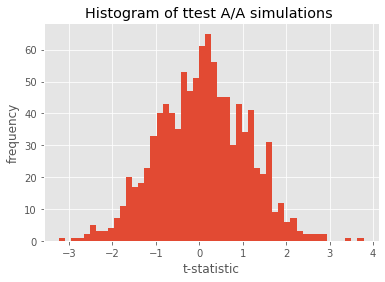

In [16]:
# Запуск симуляций A/A теста
# Распределение t статистики
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df['s1'].sample(n_s, replace = False).values
    s2 = df['s2'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[0]) # сохраняем t-статистику

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('t-statistic')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()